In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
#from mpl_toolkits.basemap import Basemap
import plotly.plotly as py
py.sign_in(username='roudgarian', api_key='o4hQBxVInVrbRO5I0Cji')
from plotly.graph_objs import *
import warnings
from scipy import stats #scientific kit (mathematics, data transformation & machine learning models)
from scipy.stats.mstats import normaltest, skewtest, kurtosistest, skew, kurtosis
import statsmodels #library for models
import seaborn as sns #Used for plotting statistical data

In [2]:
warnings.filterwarnings("ignore") 

## Importing the data 

In [3]:
training_df = pd.read_csv("trainingData.csv")
validation_df = pd.read_csv("validationData.csv")

In [4]:
training_df.head(3)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095


## Setting Timestamp

In [5]:
#The unix time stamp is a way to track time as a running total of seconds. This count starts at the Unix Epoch 
#on January 1st, 1970 at UTC. Therefore, the unix time stamp is merely the number of seconds between a particular 
#date and the Unix Epoch
training_df['TIMESTAMP'] = pd.to_datetime(training_df['TIMESTAMP'] , unit='s')
validation_df['TIMESTAMP'] = pd.to_datetime(validation_df['TIMESTAMP'] , unit='s')

In [6]:
training_df['TIMESTAMP'].head(3)

0   2013-06-20 07:35:33
1   2013-06-20 07:34:51
2   2013-06-20 07:41:35
Name: TIMESTAMP, dtype: datetime64[ns]

## 3D Location Visualization 

In [7]:
trace1 = {
  "x":list(training_df['LONGITUDE']), 
  "y": training_df['LATITUDE'], 
  "z": training_df['FLOOR'], 
  "marker": {
    "color": training_df['BUILDINGID'], 
    "colorscale": "Viridis", 
    "opacity": 1, 
    "size": 8
  }, 
  "mode": "markers", 
  "name": "Plotly 3D plot", 
  "type": "scatter3d"
}

In [8]:
data = Data([trace1])
layout = {
  "scene": {
    "xaxis": {"title": "Longitude"}, 
    "yaxis": {"title": "Atitude"}, 
    "zaxis": {"title": "Floor"}
  }, 
  "title": "3D plot Wifi Location"
}

In [9]:
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)

## Data normalisation & visualisation

In [10]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
(training_df[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']]
.astype(str)
.describe(include=['object']))

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


In [11]:
#Split dependant variables (long, lat, floor, building, spac, position) from independant variables (WAP's)
X_train = training_df.iloc[:,:520] #iloc is index location i.e. row number #get all rows for columns until 520
X_validation = validation_df.iloc[:,:520] 

Y_train = training_df.iloc[:,520:526] #get all the columns from 520 to 526
Y_validation = validation_df.iloc[:,520:526]

In [12]:
X_train.head(2)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [13]:
#Removing all WAP's +100 as they are not detected, and they interfer with the analysis
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_validation = (X_validation
             .replace(to_replace=100,value=np.nan))

In [14]:
X_stack = X_train.stack(dropna=False) #stack creates a pivot table

In [15]:
X_stack.head(5)

0  WAP001   NaN
   WAP002   NaN
   WAP003   NaN
   WAP004   NaN
   WAP005   NaN
dtype: float64

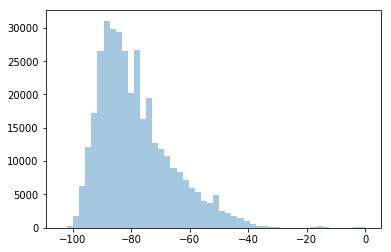

In [16]:
sns.distplot(X_stack.dropna(),kde = False)

The majority of the dBm (decibels relative to one milliwatt) lies between -90 & -70. 

In [17]:
# Proportion of out of range values +100 
sum(X_stack.isnull() == 0)/len(X_stack)
# 96.6% of WAP's are out of range

0.03460544947353394

Text(0.5, 0, 'Number of APs in range')

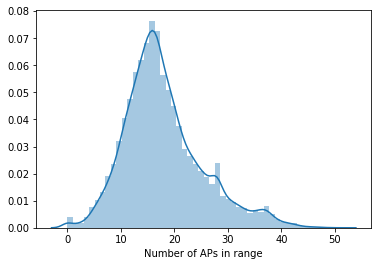

In [18]:
# WAP's which are in range
waps_in_range = (X_train
                 .notnull()
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)

sns.distplot(waps_in_range, ax = ax)
ax.set_xlabel("Number of APs in range")

Majority of the WAP's in range are between 10 & 20, with some as many as 50 WAP's in range. 

In [21]:
#Remove data with 0 WAP's in range
Y_train = (Y_train
          .loc[X_train #get the rows
              .notnull() #where it is not null
              .any(axis=1),:])

X_train = (X_train
           .loc[X_train
                .notnull()
                .any(axis=1),:])

In [22]:
# Removing columns with all NaN values
all_nan = (X_train
           .isnull()
           .all(axis=0) == False)
filtered_cols = (all_nan[all_nan]
                 .index
                 .values)

X_train = X_train.loc[:,filtered_cols]
X_validation = X_validation.loc[:,filtered_cols]

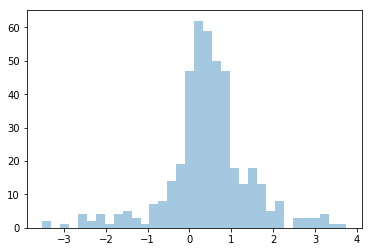

In [23]:
# Finding skewness
X_skew = X_train.skew()

sns.distplot(X_skew.dropna(),kde=False)

Generally a positive skewness can be observed between 0 & 1

In [24]:
#Normalizing the data and replaceing the NA's with the minimum RSSI value
X_exp_train = np.power(10,X_train/10,)
X_exp_validation = np.power(10,X_validation/10)

abs_min = (X_exp_train.apply(min).min())

X_exp_train.fillna(abs_min,inplace=True)
X_exp_validation.fillna(abs_min,inplace=True)

In [25]:
#Describe the distribution 
def skew_score(s):
    return float(skew(s).data) #The average skewness (positive is positive skewness and vice verse)

def kurtosis_score(s):
    return kurtosis(s) #The probability in the tails (how likely is extreme in the distribution)

def in_range(s):
    return (s > abs_min).sum()

X_norm = pd.DataFrame({'Sample_Size': X_exp_train.apply(in_range),
                         'Skewness': X_exp_train.apply(skew_score),
                         'Kurtosis': X_exp_train.apply(kurtosis_score),
                        })

X_norm.head(15)

,Sample_Size,Skewness,Kurtosis
WAP001,18,38.296999,1589.911556
WAP002,19,38.774718,1570.412878
WAP005,40,29.692772,988.020774
WAP006,308,49.203758,2649.644164
WAP007,578,48.199343,2544.345308
WAP008,677,15.905379,271.572833
WAP009,595,36.943490,1607.562517
WAP010,87,33.682378,1314.161272
WAP011,2956,91.377383,8749.417194
WAP012,2983,46.709112,2186.418420


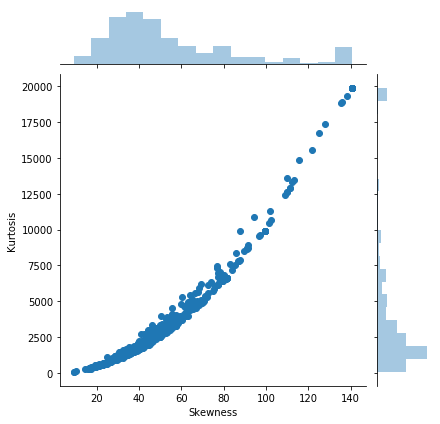

In [26]:
sns.jointplot(y="Kurtosis", x="Skewness", stat_func= None, data=X_norm)

The higher the skewness, the significantly higher kurtosis, which means that there are a few columns that have extremly heavy tails, more so than a normal distribution. (Alot of data in the tails of some points)

In [27]:
#Box-Cox Transformation which is used to transform a skewed distribution to a normal distribution
def box_cox_lambda(s):
    _, maxlog = stats.boxcox(s)
    return maxlog

lambda_bc = X_exp_train.apply(box_cox_lambda)

X_boxcox_train = X_exp_train
X_boxcox_validation = X_exp_validation

for wap in X_boxcox_train:
 
    X_boxcox_train.loc[:,wap] = stats.boxcox(X_exp_train.loc[:,wap],lmbda = lambda_bc.loc[wap])
    
    X_boxcox_validation.loc[:,wap] = stats.boxcox(X_exp_validation.loc[:,wap],lmbda = lambda_bc.loc[wap])

In [28]:
# After Box-Cox #to create the normal distribution
X_norm_post_boxcox = pd.DataFrame({'Skewness': X_boxcox_train.apply(skew_score),
                         'Kurtosis': X_boxcox_train.apply(kurtosis_score),
                         'BoxCox_Lambda': lambda_bc})

X_norm_post_boxcox.head(10)

,Skewness,Kurtosis,BoxCox_Lambda
WAP001,0.000000,-3,5.636369
WAP002,0.000000,-3,5.636369
WAP005,0.000000,-3,5.636369
WAP006,0.000000,--,-15.078885
WAP007,5.602818,29.3916,-6.989974
WAP008,5.135374,24.3721,-6.063101
WAP009,5.514591,28.4107,-5.750808
WAP010,0.000000,-3,5.636369
WAP011,1.982143,1.93886,-0.975030
WAP012,1.965486,1.87163,-0.968725


Text(0.5, 1.0, 'Post- Box-Cox')

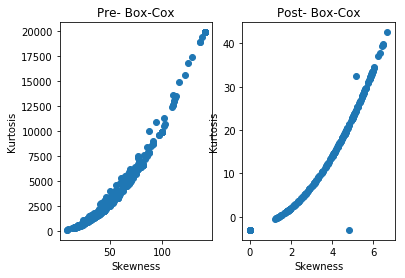

In [29]:
#Plot before and after skewness
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.scatter(y="Kurtosis", x="Skewness", data=X_norm)
ax1.set_xlabel("Skewness")
ax1.set_ylabel("Kurtosis")
ax1.set_title("Pre- Box-Cox")

ax2.scatter(y="Kurtosis", x="Skewness", data=X_norm_post_boxcox)
ax2.set_xlabel("Skewness")
ax2.set_ylabel("Kurtosis")
ax2.set_title("Post- Box-Cox")

ValueError: color kwarg must have one color per data set. 459 data sets and 1 colors were provided

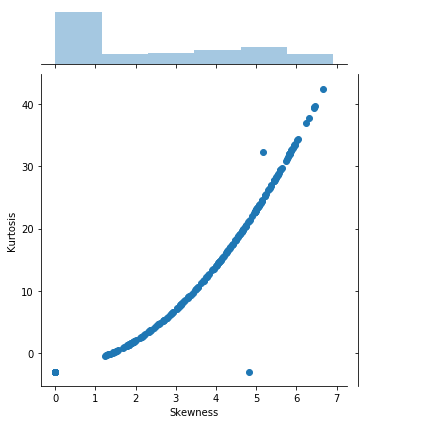

In [31]:
sns.jointplot(y="Kurtosis", x="Skewness", stat_func = None,data=X_norm_post_boxcox)